In [3]:
pip install fake_useragent

In [4]:
import requests
from bs4 import BeautifulSoup
import json
import time
import pandas as pd
import numpy as np
from fake_useragent import UserAgent

# Base URL for Eventbrite event listings with a placeholder for the page number
base_url = 'https://www.eventbrite.com/d/canada--toronto/all-events/?page={}'

# Number of pages to scrape
num_pages = 50

# User-Agent rotation setup
ua = UserAgent()

# List to store all event data
all_events = []

# Loop through pages
for page_num in range(1, num_pages + 1):
    success = False  # Flag to handle retries
    while not success:
        # Update headers with a random User-Agent
        headers = {"User-Agent": ua.random}

        # Make the request
        r = requests.get(base_url.format(page_num), headers=headers)

        # Check response status
        if r.status_code == 429:  # Rate limiting
            print(f"Rate limit hit on page {page_num}. Retrying after delay...")
            time.sleep(30)  # Backoff delay for 429
        elif r.status_code == 200:
            print(f"Success: {r.status_code} for page {page_num}")
            success = True  # Exit retry loop

            # Parse the HTML content
            soup = BeautifulSoup(r.content, 'html.parser')

            # Extract JSON-LD script tag
            script_tag = soup.find('script', type='application/ld+json')

            if script_tag:
                try:
                    json_data = json.loads(script_tag.string)

                    # Extract events data from JSON-LD
                    events = json_data.get("itemListElement", [])

                    for event_data in events:
                        event = event_data.get('item', {})
                        event_name = event.get('name', 'N/A')
                        event_description = event.get('description', 'N/A')
                        event_url = event.get('url', 'N/A')
                        event_location = event.get('location', {}).get('name', 'N/A')
                        event_start = event.get('startDate', 'N/A')
                        event_end = event.get('endDate', 'N/A')

                        # Geo information (latitude and longitude)
                        geo_info = event.get('location', {}).get('geo', {})
                        latitude = geo_info.get('latitude', 'N/A')
                        longitude = geo_info.get('longitude', 'N/A')

                        # Append event details to the list
                        all_events.append({
                            'name': event_name,
                            'description': event_description,
                            'url': event_url,
                            'location': event_location,
                            'start_date': event_start,
                            'end_date': event_end,
                            'latitude': latitude,
                            'longitude': longitude
                        })
                except Exception as e:
                    print(f"Error parsing JSON-LD data on page {page_num}: {e}")
            else:
                print(f"No JSON-LD script tag found on page {page_num}")
        else:
            print(f"Failed: {r.status_code} for page {page_num}")
            break  # Exit the loop for non-retriable errors

        # Add a delay between requests to avoid being flagged
        time.sleep(10)

# Save the scraped data to a JSON file
json_file = 'event_data.json'
with open(json_file, 'w', encoding='utf-8') as file:
    json.dump(all_events, file, ensure_ascii=False, indent=4)

print(f"Data successfully saved to {json_file}")

# Print a summary of the scraped events
for idx, event in enumerate(all_events[:10], start=1):  # Display the first 10 events
    print(f"Event {idx}:")
    print(f"Name: {event['name']}")
    print(f"Description: {event['description']}")
    print(f"URL: {event['url']}")
    print(f"Location: {event['location']}")
    print(f"Start Date: {event['start_date']}")
    print(f"End Date: {event['end_date']}")
    print(f"Latitude: {event['latitude']}")
    print(f"Longitude: {event['longitude']}")
    print()

Success: 200 for page 1
Success: 200 for page 2
Success: 200 for page 3
Success: 200 for page 4
Success: 200 for page 5
Success: 200 for page 6
Success: 200 for page 7
Success: 200 for page 8
Success: 200 for page 9
Success: 200 for page 10
Success: 200 for page 11
Success: 200 for page 12
Success: 200 for page 13
Success: 200 for page 14
Success: 200 for page 15
Success: 200 for page 16
Success: 200 for page 17
Success: 200 for page 18
Success: 200 for page 19
Success: 200 for page 20
Success: 200 for page 21
Success: 200 for page 22
Success: 200 for page 23
Success: 200 for page 24
Success: 200 for page 25
Success: 200 for page 26
Success: 200 for page 27
Success: 200 for page 28
Success: 200 for page 29
Success: 200 for page 30
Success: 200 for page 31
Success: 200 for page 32
Success: 200 for page 33
Success: 200 for page 34
Success: 200 for page 35
Success: 200 for page 36
Success: 200 for page 37
Success: 200 for page 38
Success: 200 for page 39
Success: 200 for page 40
Success: 

In [5]:
df = pd.DataFrame(all_events)
# Drop duplicates if there are any
df = df.drop_duplicates()

# Convert date columns to datetime format
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

# Drop rows with missing important data (e.g., start_date or location)
df = df.dropna(subset=['start_date', 'location'])

In [6]:
# Extract day of the week and hour of the start time for trend analysis
df['day_of_week'] = df['start_date'].dt.day_name()
df['start_hour'] = df['start_date'].dt.hour

# Calculate event duration in hours
df['duration_hours'] = (df['end_date'] - df['start_date']).dt.total_seconds() / 3600

# Categorize event duration for easier visualization
duration_bins = [0, 2, 4, 6, 8, 12, 24, df['duration_hours'].max()]
duration_labels = ['0-2 hours', '2-4 hours', '4-6 hours', '6-8 hours', '8-12 hours', '12-24 hours', '24+ hours']
df['duration_category'] = pd.cut(df['duration_hours'], bins=duration_bins, labels=duration_labels, right=False)
df['duration_days'] = (df['end_date'] - df['start_date']).dt.days

In [7]:
# Convert latitude and longitude to numeric
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Drop rows where latitude or longitude is missing if geolocation is essential
df = df.dropna(subset=['latitude', 'longitude'])

In [8]:
# Basic text cleaning for event descriptions
df['description'] = df['description'].str.replace('\n', ' ').str.lower().str.strip()

In [10]:
# Display first few rows to verify data preparation
print(df.head())

# Check for any remaining missing values
print("\nMissing values:\n", df.isnull().sum())

                                                name  \
0                              Ghibli Holiday Market   
1         The Walrus Talks: Canada's Health Security   
2         Sleigh the Holidays! With Inkloosiv Voices   
3  (Free) Dress rehearsal for Messiah concert at ...   
4              St. Paul's Christmas Concert & Market   

                                         description  \
0  hey fellow studio ghibli fans, get ready for a...   
1  how are we preparing to manage and support can...   
2  a celebration of chosen family, community, and...   
3  messiah by g. f. handel presented by the choir...   
4  join us at st. paul's bloor street for an ench...   

                                                 url  \
0  https://www.eventbrite.ca/e/ghibli-holiday-mar...   
1  https://www.eventbrite.ca/e/the-walrus-talks-c...   
2  https://www.eventbrite.ca/e/sleigh-the-holiday...   
3  https://www.eventbrite.ca/e/free-dress-rehears...   
4  https://www.eventbrite.ca/e/st-pauls-christ

In [11]:
# Descriptive statistics table
descriptive_stats = df.describe()

# Missing values table
missing_values = df.isnull().sum().to_frame(name='Missing Values')

# Display tables
print("Descriptive Statistics:")
display(descriptive_stats)

print("\nMissing Values:")
display(missing_values)

Descriptive Statistics:


,start_date,end_date,latitude,longitude,start_hour,duration_hours,duration_days
count,995,995,995.000000,995.000000,995.0,995.000000,995.000000
mean,2024-12-16 20:43:10.552763648,2024-12-17 00:54:59.698492416,43.668756,-79.412238,0.0,4.196985,0.174874
min,2024-12-01 00:00:00,2024-12-01 00:00:00,43.548132,-79.637410,0.0,0.000000,0.000000
25%,2024-12-07 00:00:00,2024-12-07 00:00:00,43.647736,-79.427139,0.0,0.000000,0.000000
50%,2024-12-12 00:00:00,2024-12-12 00:00:00,43.656085,-79.400753,0.0,0.000000,0.000000
75%,2024-12-20 00:00:00,2024-12-21 00:00:00,43.670993,-79.383184,0.0,0.000000,0.000000
max,2025-05-03 00:00:00,2025-05-03 00:00:00,43.832155,-79.220921,0.0,168.000000,7.000000
std,NaN,NaN,0.042527,0.061616,0.0,11.382211,0.474259



Missing Values:


,Missing Values
name,0
description,0
url,0
location,0
start_date,0
end_date,0
latitude,0
longitude,0
day_of_week,0
start_hour,0


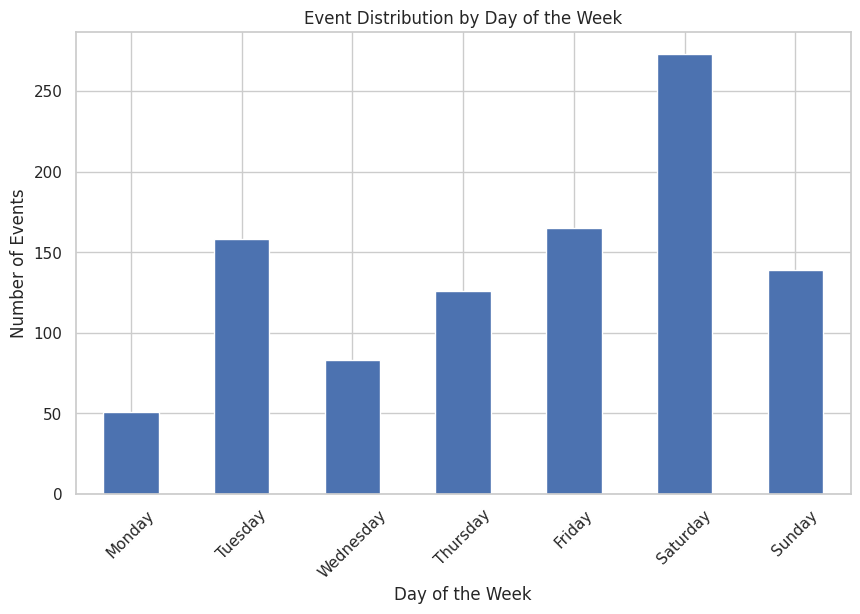

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set(style="whitegrid")

# Define the correct order for days of the week
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Set 'day_of_week' as a categorical type with the specified order
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

# Plot the count of events by day of the week
plt.figure(figsize=(10, 6))
df['day_of_week'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')
plt.title('Event Distribution by Day of the Week')
plt.xticks(rotation=45)
plt.show()


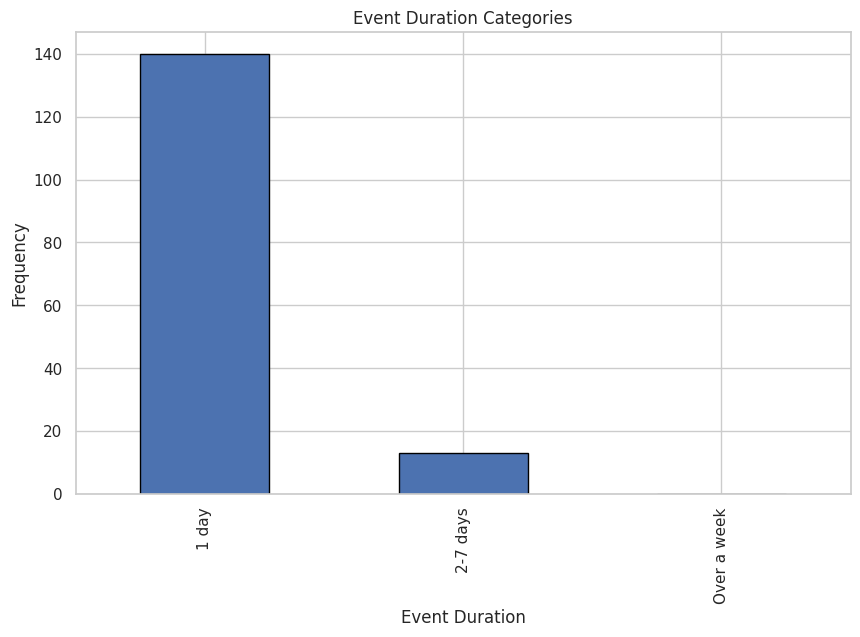

In [13]:
# Categorize events by duration
df['duration_category'] = pd.cut(df['duration_days'],
                                 bins=[0, 1, 7, 30],
                                 labels=['1 day', '2-7 days', 'Over a week'])

# Plot a bar chart of event duration categories
plt.figure(figsize=(10, 6))
df['duration_category'].value_counts().plot(kind='bar', edgecolor='black')
plt.xlabel('Event Duration')
plt.ylabel('Frequency')
plt.title('Event Duration Categories')
plt.show()

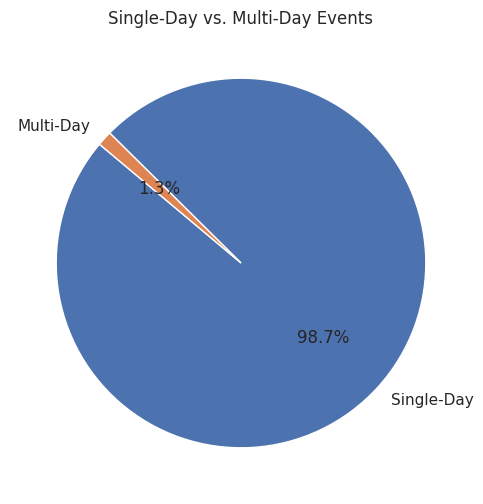

In [14]:
# Classify events as single-day or multi-day
df['event_type'] = np.where(df['duration_days'] <= 1, 'Single-Day', 'Multi-Day')

# Plot the count of single-day vs multi-day events
plt.figure(figsize=(10, 6))
df['event_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Single-Day vs. Multi-Day Events')
plt.ylabel('')  # Hide y-axis label for better visualization
plt.show()

<ipython-input-15-9207bea57ac4>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_day_counts = df.groupby(['day_of_week', 'duration_category']).size().unstack()


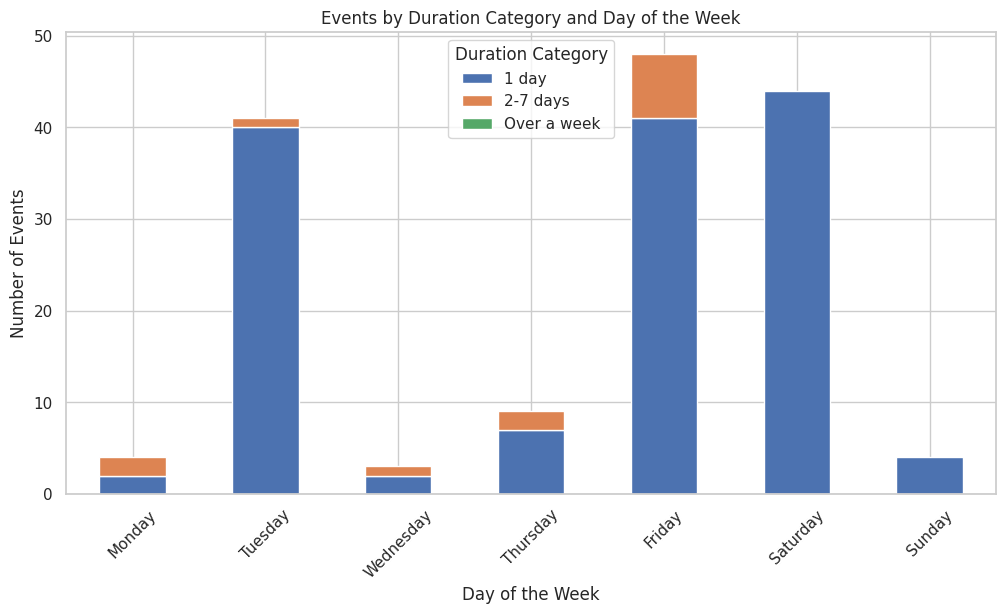

In [15]:
# Plot stacked bar plot by duration category and day of the week
duration_day_counts = df.groupby(['day_of_week', 'duration_category']).size().unstack()
duration_day_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xlabel('Day of the Week')
plt.ylabel('Number of Events')
plt.title('Events by Duration Category and Day of the Week')
plt.legend(title='Duration Category')
plt.xticks(rotation=45)
plt.show()

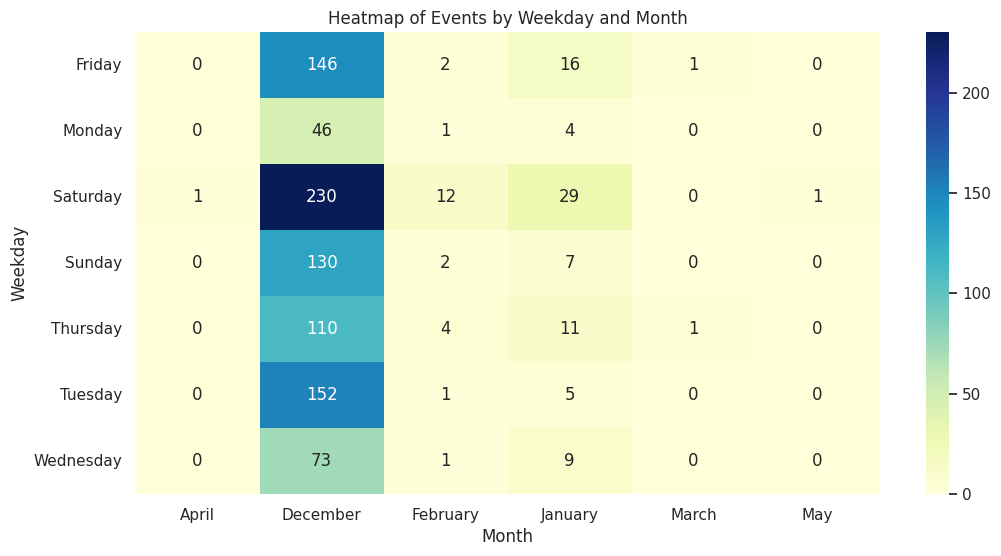

In [16]:
# Extract weekday and month
df['weekday'] = df['start_date'].dt.day_name()
df['month'] = df['start_date'].dt.month_name()

# Pivot table to count events by weekday and month
heatmap_data = df.pivot_table(index='weekday', columns='month', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap of Events by Weekday and Month')
plt.xlabel('Month')
plt.ylabel('Weekday')
plt.show()


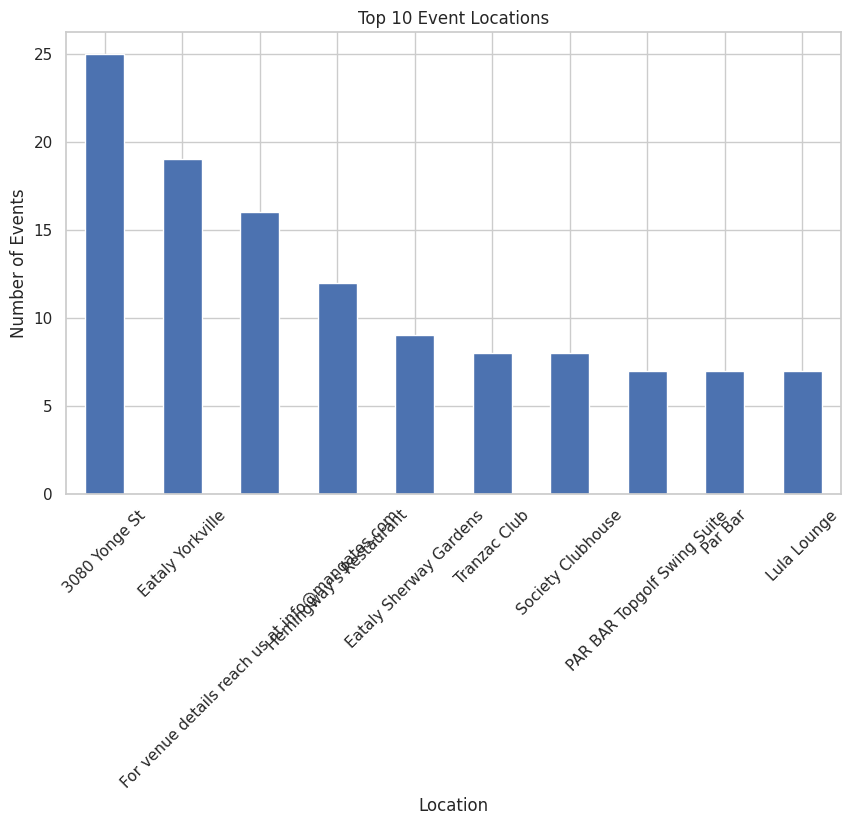

In [17]:
# Count of unique locations or categories
plt.figure(figsize=(10, 6))
df['location'].value_counts().head(10).plot(kind='bar')
plt.xlabel('Location')
plt.ylabel('Number of Events')
plt.title('Top 10 Event Locations')
plt.xticks(rotation=45)
plt.show()

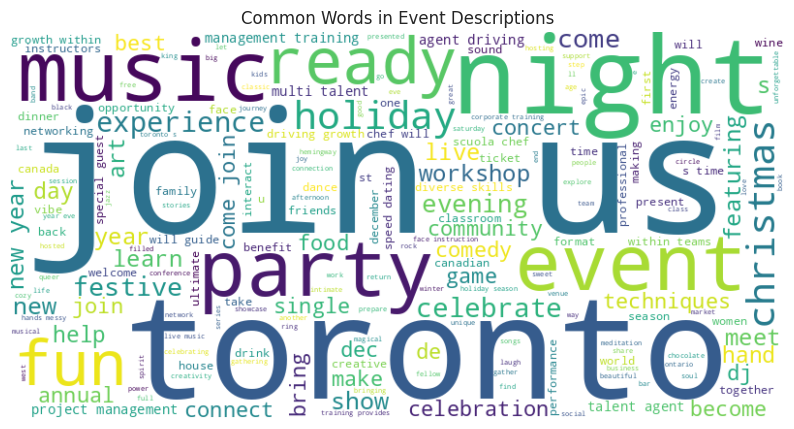

In [18]:
from wordcloud import WordCloud

# Combine all descriptions into a single string
text = ' '.join(df['description'].fillna(''))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Event Descriptions')
plt.show()

In [19]:
import folium
from folium.plugins import HeatMap

# Create a base map centered around Toronto
toronto_map = folium.Map(location=[43.65107, -79.347015], zoom_start=11)

# Prepare the data for the heatmap
heat_data = df[['latitude', 'longitude']].dropna().values

# Add heatmap to the map
HeatMap(heat_data, radius=10).add_to(toronto_map)

# Display the map
toronto_map


In [20]:
import pandas as pd

# Example: Convert all_events to a DataFrame
event_df = pd.DataFrame(all_events)

# Check for required columns and clean data
required_columns = ['event_name', 'latitude', 'longitude']
for col in required_columns:
    if col not in event_df.columns:
        print(f"Missing column: {col}")

# Drop rows with missing geolocation data
event_df = event_df.dropna(subset=['latitude', 'longitude'])


Missing column: event_name


In [21]:
import folium
from folium.plugins import MarkerCluster

# Create a base map centered on Toronto
map_cluster = folium.Map(location=[43.7, -79.4], zoom_start=10)

# Add a MarkerCluster layer
marker_cluster = MarkerCluster().add_to(map_cluster)

# Add markers for each event
for _, row in event_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name']
    ).add_to(marker_cluster)

# Save the map
map_cluster.save("updated_clustered_map.html")

In [22]:
from folium.plugins import HeatMap

# Prepare heatmap data
heat_data = [[row['latitude'], row['longitude']] for _, row in event_df.iterrows()]

# Add heatmap to the map
heatmap = folium.Map(location=[43.7, -79.4], zoom_start=10)
HeatMap(heat_data).add_to(heatmap)

# Save the heatmap
heatmap.save("updated_heatmap.html")


In [23]:
# Assuming `map_cluster` is your folium map object
map_cluster

In [24]:
# Save the scraped data to your Google Drive as a JSON file
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to save the JSON file in Google Drive
json_file_path = '/content/drive/My Drive/Eventbrite/event_data.json'

# Save the data
with open(json_file_path, 'w', encoding='utf-8') as file:
    json.dump(all_events, file, ensure_ascii=False, indent=4)

print(f"Data successfully saved to {json_file_path}")

Mounted at /content/drive
Data successfully saved to /content/drive/My Drive/Eventbrite/event_data.json
